In [1]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import gzip
from datetime import datetime, timedelta
from statistics import mean
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import shapiro, anderson

In [2]:
def retrieve_data(varname, filename):
    df = pd.read_csv(filename)
    df["Date"] = pd.to_datetime(df["Date"])
    return df

In [7]:
files = {
    # varname: filename
    "S&P500": "Dataset v3/SP500_combined_data_20220422.csv",
    "NASDAQ": "Dataset v3/nasdaq_combined_data_20220422.csv",
    "US30": "Dataset v3/US30_combined_data_20220422.csv",
}

df = pd.DataFrame()
for file in files:
    df_temp = retrieve_data(file, files[file])
    if df.empty:
        df = df_temp
    else:
        cols_to_use = df_temp.columns.difference(df.columns).tolist()
        cols_to_use.append('Date')
        df = pd.merge(df, df_temp[cols_to_use], on="Date")
df

,Date,AAPL_Volume,AAPL_relative_change_perc_1,AAPL_relative_change_perc_10,AAPL_relative_change_perc_20,AAPL_relative_change_perc_5,AAPL_relative_change_perc_50,AMZN_Volume,AMZN_relative_change_perc_1,AMZN_relative_change_perc_10,...,US30_week_high_1,US30_week_high_10,US30_week_high_52,US30_week_low_1,US30_week_low_10,US30_week_low_52,US30_williams_R_10,US30_williams_R_20,US30_williams_R_5,US30_williams_R_50
0,2009-07-01,414270000.0,-0.003906,0.000911,-0.000532,0.007047,0.001238,6980000.0,-0.033404,-0.002406,...,8580.47,8877.93,12062.19,8259.43,7804.21,6469.95,0.579532,1.664179,-0.448882,-2.802991
1,2009-07-02,370620000.0,-0.007937,0.000323,-0.002229,-0.000314,0.001261,7220000.0,-0.022069,-0.003140,...,8580.47,8877.93,11924.19,8280.74,7804.21,6469.95,2.684402,4.032482,0.907761,-1.334182
2,2009-07-06,498690000.0,0.000000,-0.000691,-0.002036,-0.004322,0.001438,7370000.0,-0.004461,-0.004572,...,8580.47,8877.93,11924.19,8205.99,7938.98,6469.95,2.433839,3.701921,2.134698,-1.971295
3,2009-07-07,461780000.0,-0.022222,-0.000722,-0.003148,-0.006813,0.001129,6490000.0,-0.036929,-0.004309,...,8580.47,8877.93,11924.19,8154.38,7938.98,6469.95,1.836842,3.459246,3.549357,-0.212291
4,2009-07-08,575930000.0,0.010309,0.001952,-0.002243,-0.004751,0.001062,8540000.0,0.011771,-0.001498,...,8580.47,8877.93,11867.11,8087.19,7938.98,6469.95,2.278258,7.996545,2.294612,-0.412482
5,2009-07-09,343150000.0,-0.010163,0.000522,-0.002062,-0.006002,0.000768,6360000.0,-0.001917,-0.003318,...,8503.23,8877.93,11867.11,8087.19,8017.91,6469.95,1.455171,3.342702,2.988566,-0.599358
6,2009-07-10,445270000.0,0.016427,-0.000722,-0.001442,-0.001130,0.001051,5980000.0,0.001419,-0.007095,...,8327.97,8877.93,11867.11,8087.19,8087.19,6469.95,1.488724,5.161680,1.603263,0.463365
7,2009-07-13,483770000.0,0.020080,-0.000718,0.000268,0.002886,0.001542,8050000.0,0.043551,-0.005158,...,8331.68,8877.93,11867.11,8087.19,8087.19,6469.95,2.033675,5.336149,-0.030415,-0.141668
8,2009-07-14,347500000.0,0.001972,0.000456,0.000367,0.007725,0.001358,4550000.0,0.005768,-0.003579,...,8361.23,8877.93,11867.11,8087.19,8087.19,6469.95,1.668331,1.990073,-0.192986,-1.159170
9,2009-07-15,485580000.0,0.013514,0.001808,0.001145,0.008366,0.001017,6340000.0,0.018675,-0.001760,...,8628.23,8877.93,11867.11,8093.31,8087.19,6469.95,-0.334975,0.190199,-2.997733,-0.819624


In [25]:
df.columns.tolist()

['Date',
 'AAPL_Volume',
 'AAPL_relative_change_perc_1',
 'AAPL_relative_change_perc_10',
 'AAPL_relative_change_perc_20',
 'AAPL_relative_change_perc_5',
 'AAPL_relative_change_perc_50',
 'AMZN_Volume',
 'AMZN_relative_change_perc_1',
 'AMZN_relative_change_perc_10',
 'AMZN_relative_change_perc_20',
 'AMZN_relative_change_perc_5',
 'AMZN_relative_change_perc_50',
 'AUDUSD_relative_change_perc_1',
 'AUDUSD_relative_change_perc_10',
 'AUDUSD_relative_change_perc_20',
 'AUDUSD_relative_change_perc_5',
 'AUDUSD_relative_change_perc_50',
 'BrentOil_F_Volume',
 'BrentOil_F_relative_change_perc_1',
 'BrentOil_F_relative_change_perc_10',
 'BrentOil_F_relative_change_perc_20',
 'BrentOil_F_relative_change_perc_5',
 'BrentOil_F_relative_change_perc_50',
 'CAC40_F_Volume',
 'CAC40_F_relative_change_perc_1',
 'CAC40_F_relative_change_perc_10',
 'CAC40_F_relative_change_perc_20',
 'CAC40_F_relative_change_perc_5',
 'CAC40_F_relative_change_perc_50',
 'CAC40_Volume',
 'CAC40_relative_change_perc_1'

In [8]:
col_name = "_relative_change_perc_1"

closes = []
for column in df.columns.tolist():
    if column[-len(col_name):] == col_name:
        closes.append(column)
closes

# col_name = "SP500"

# closes = []
# for column in df.columns.tolist():
#     if column[:len(col_name)] == col_name:
#         closes.append(column)
# closes

['AAPL_relative_change_perc_1',
 'AMZN_relative_change_perc_1',
 'AUDUSD_relative_change_perc_1',
 'BrentOil_F_relative_change_perc_1',
 'CAC40_F_relative_change_perc_1',
 'CAC40_relative_change_perc_1',
 'Copper_F_relative_change_perc_1',
 'Corn_F_relative_change_perc_1',
 'EURUSD_relative_change_perc_1',
 'FB_relative_change_perc_1',
 'GBPUSD_relative_change_perc_1',
 'GER30_F_relative_change_perc_1',
 'GER30_relative_change_perc_1',
 'GOOGL_relative_change_perc_1',
 'GOOG_relative_change_perc_1',
 'Gold_F_relative_change_perc_1',
 'HS50_F_relative_change_perc_1',
 'HS50_relative_change_perc_1',
 'MSFT_relative_change_perc_1',
 'NASDAQ_F_relative_change_perc_1',
 'NASDAQ_relative_change_perc_1',
 'NIKKEI225_F_relative_change_perc_1',
 'NIKKEI225_relative_change_perc_1',
 'NZDUSD_relative_change_perc_1',
 'NaturalGas_F_relative_change_perc_1',
 'SP500_F_relative_change_perc_1',
 'SP500_relative_change_perc_1',
 'SSE50_F_relative_change_perc_1',
 'SSE50_relative_change_perc_1',
 'Silve

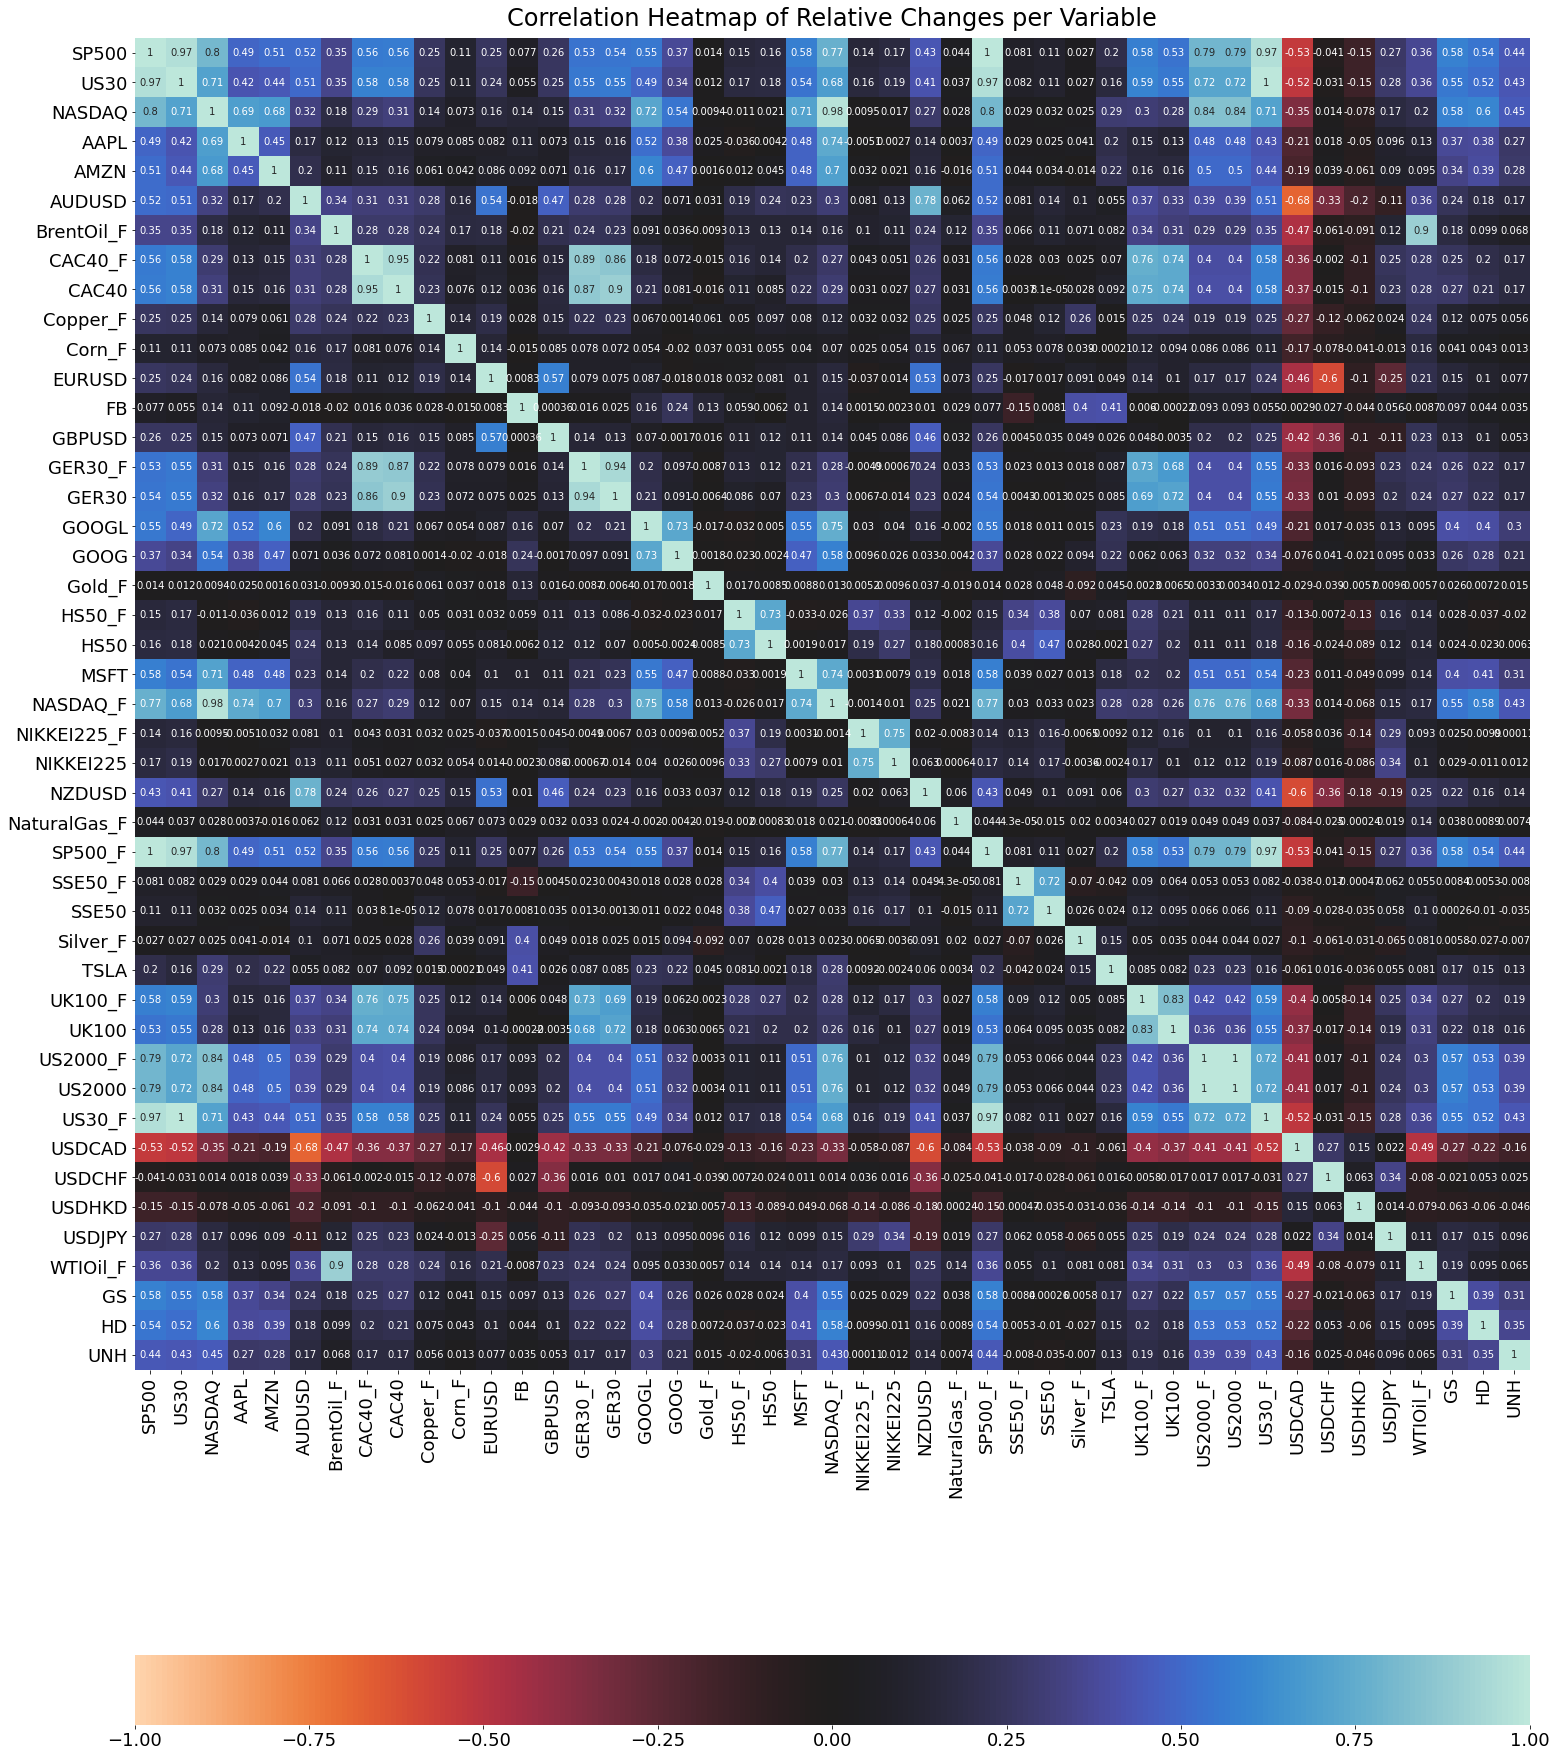

'\nCLOSE PRICES\n\n    It can be seen that there is significant correlation between thee indices, index futures and the SP500 index. \n    It can also be seen that the HS50 and SSE50 indices and index futures have the lowest correlaiton.\n\n    It can be seen that there is a significant negative correlation between the S&P500 and most commodities.\n    This is in line with findings presented by ..., suggesting that commodities provide a safe haven for \n        stock market investors when the stock market decreases (and increases?)\n\n    It can also be seen that the forex pairs with USD as the base currency show a significant positive correlation,\n    where the forex pairs with another currency as the base currency show a significant negative correlation. \n    This is logical.\n\n    With this, the relation between the different variables is demonstrated.\n\n    Moreover, many of the different variables seem to be correlated as well\n\nRELATIVE MOVEMENTS\n\n    Relatively large valu

In [18]:
# col_name = "_relative_change_perc_1"
df_temp = df[closes]
cols = df_temp.columns

new_cols = []
for col in cols:
    new_cols.append(col[:-len(col_name)])
#     new_cols.append(col[len(col_name)+1:])
df_temp.columns = new_cols

new_cols.remove("NASDAQ")
new_cols.insert(0, "NASDAQ")
new_cols.remove("US30")
new_cols.insert(0, "US30")
new_cols.remove("SP500")
new_cols.insert(0, "SP500")

df_temp = df_temp[new_cols]

df_close_corr = df_temp.corr()
plt.figure(figsize=(25, 35)) # 30, 20
# Set the range of values to be displayed on the colormap from -1 to 1
heatmap = sns.heatmap(df_close_corr, vmin=-1, vmax=1, annot=True, cmap='icefire_r', cbar_kws = dict(use_gridspec=False,location="bottom"))
heatmap.set_title('Correlation Heatmap of Relative Changes per Variable', fontdict={'fontsize':24}, pad=12)
heatmap.set_xticklabels(heatmap.get_xmajorticklabels(), fontsize=18)
heatmap.set_yticklabels(heatmap.get_ymajorticklabels(), fontsize=18)

cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=18)

# plt.savefig("Plots/Pearson Heatmap ALL relative.png")
plt.show()

"""
CLOSE PRICES

    It can be seen that there is significant correlation between thee indices, index futures and the SP500 index. 
    It can also be seen that the HS50 and SSE50 indices and index futures have the lowest correlaiton.

    It can be seen that there is a significant negative correlation between the S&P500 and most commodities.
    This is in line with findings presented by ..., suggesting that commodities provide a safe haven for 
        stock market investors when the stock market decreases (and increases?)

    It can also be seen that the forex pairs with USD as the base currency show a significant positive correlation,
    where the forex pairs with another currency as the base currency show a significant negative correlation. 
    This is logical.

    With this, the relation between the different variables is demonstrated.

    Moreover, many of the different variables seem to be correlated as well

RELATIVE MOVEMENTS

    Relatively large values of correlation between SP500, US30, US2000, NASDAQ, GER30, UK100, CAC40 and their futures
    Generally fairly large values of correlation between index and index futures
    Fairly large values of correlation between APPL, AMZN, GOOGL, GOOG and MSFT
    Low values of correlation between commodities and indices
    AUDUSD and NZDUSD have fairly large correlation values between the US30 and SP500
    USDCAD has a fairly large negative correlation with the indices except the SSE50, HS50 and NIKKEI225

"""

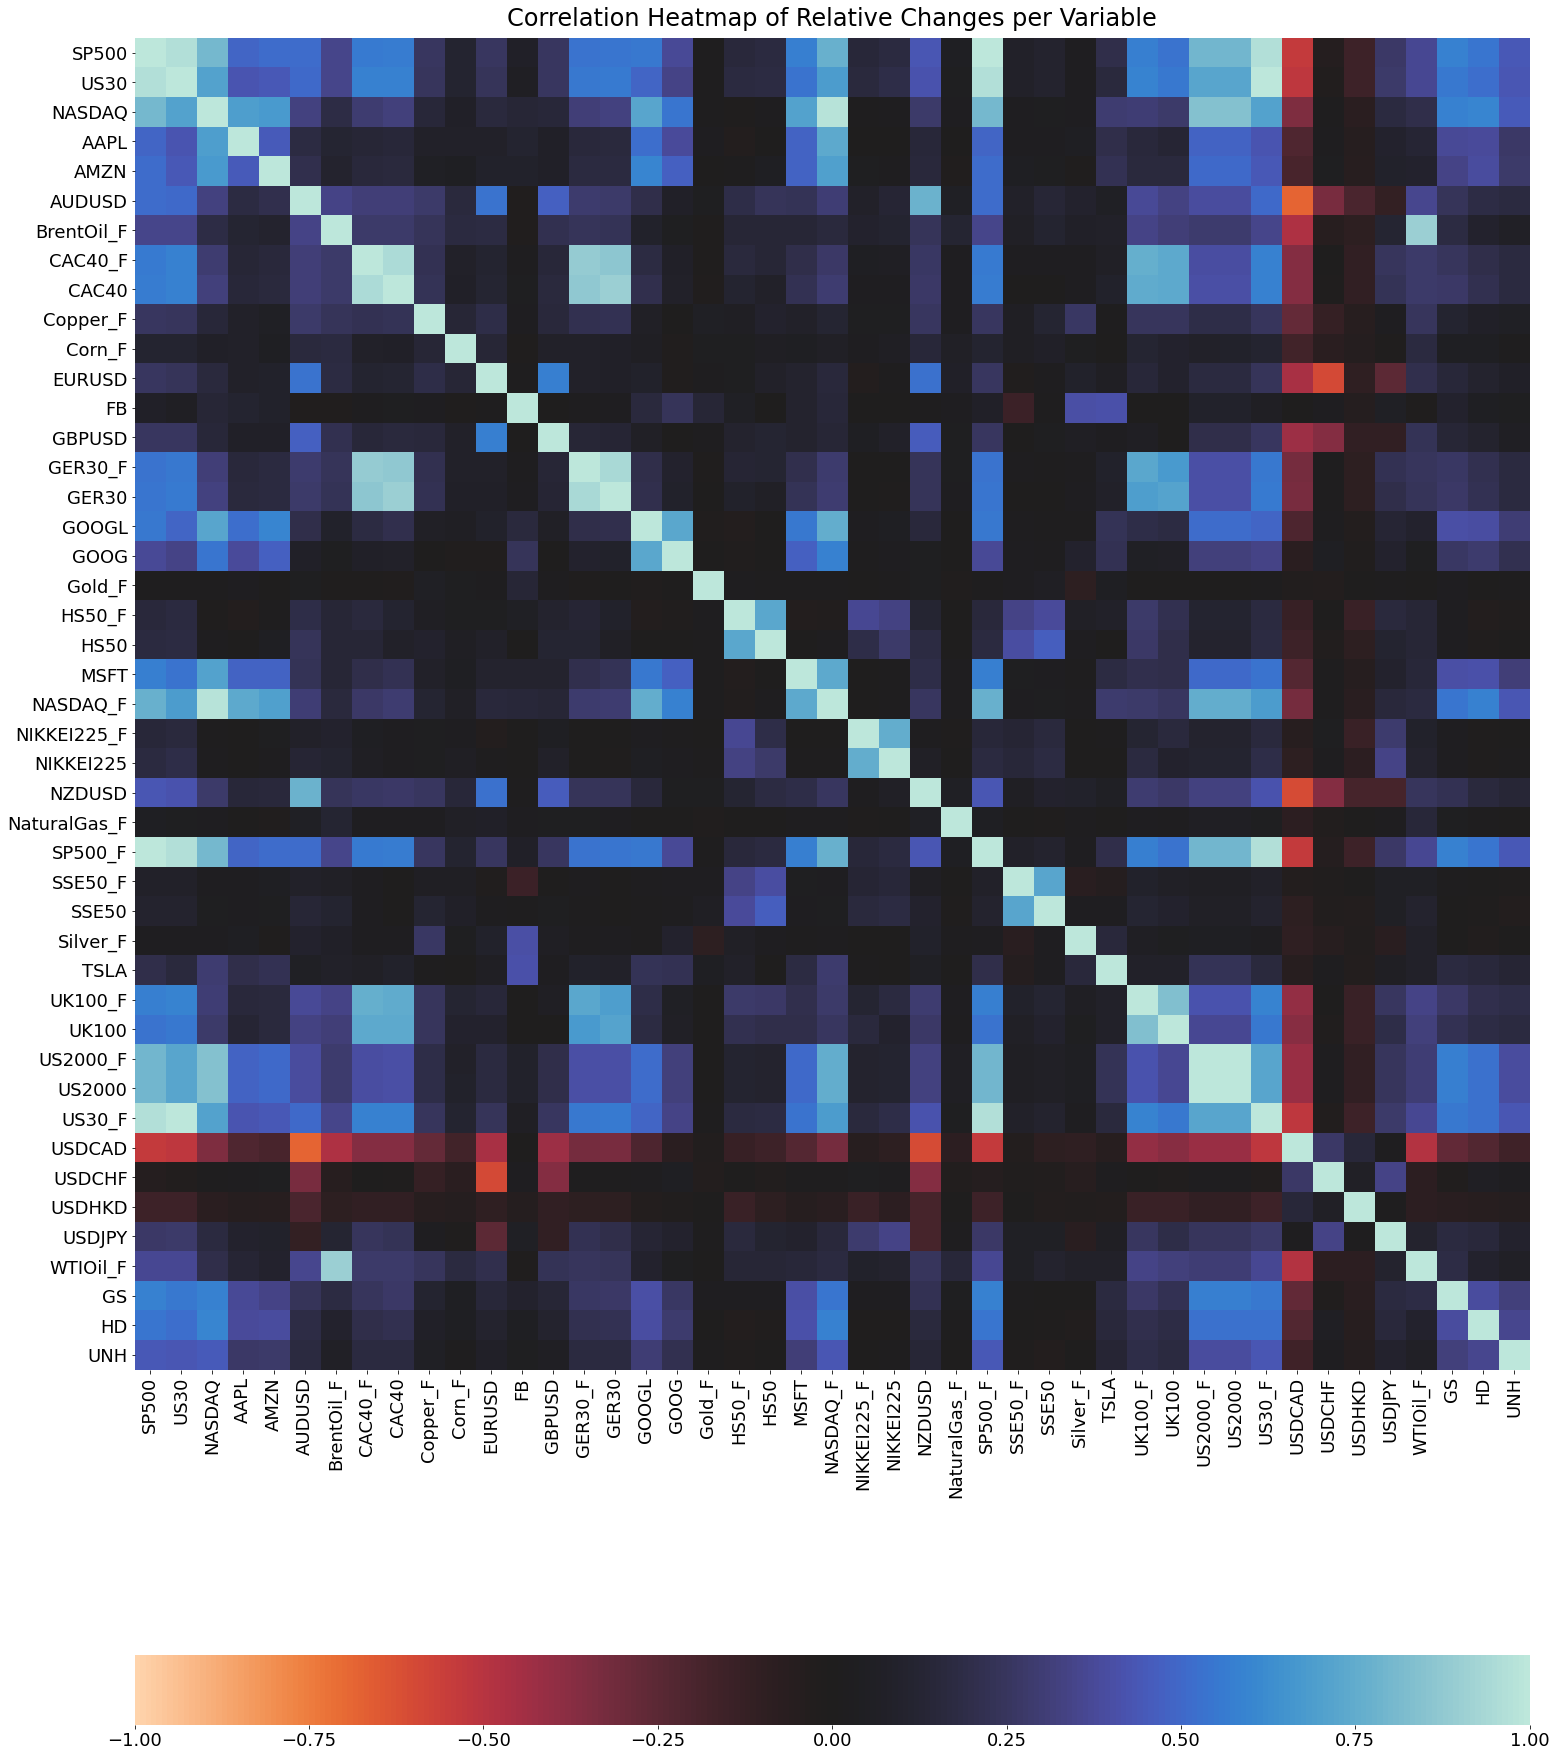

In [17]:
# col_name = "_relative_change_perc_1"
df_temp = df[closes]
cols = df_temp.columns

new_cols = []
for col in cols:
    new_cols.append(col[:-len(col_name)])
#     new_cols.append(col[len(col_name)+1:])
df_temp.columns = new_cols

new_cols.remove("NASDAQ")
new_cols.insert(0, "NASDAQ")
new_cols.remove("US30")
new_cols.insert(0, "US30")
new_cols.remove("SP500")
new_cols.insert(0, "SP500")

df_temp = df_temp[new_cols]

df_close_corr = df_temp.corr()
plt.figure(figsize=(25, 35)) # 30, 20
# Set the range of values to be displayed on the colormap from -1 to 1
heatmap = sns.heatmap(df_close_corr, vmin=-1, vmax=1, annot=False, cmap='icefire_r', cbar_kws = dict(use_gridspec=False,location="bottom"))
heatmap.set_title('Correlation Heatmap of Relative Changes per Variable', fontdict={'fontsize':24}, pad=12)
heatmap.set_xticklabels(heatmap.get_xmajorticklabels(), fontsize=18)
heatmap.set_yticklabels(heatmap.get_ymajorticklabels(), fontsize=18)

cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=18)

plt.savefig("Plots/Pearson Heatmap ALL relative.png")
plt.show()



In [19]:
alpha = 0.05
for col in df_temp.columns:

    statistic, p = shapiro(df_temp[col])
    if p >= 0.05:
        print(col, f"\t H0 accepted with p-value of {p}")
    else:
        print(col, f"\t H0 rejected with p-value of {p}")

SP500 	 H0 rejected with p-value of 2.0533400138313374e-32
US30 	 H0 rejected with p-value of 6.168975545205752e-31
NASDAQ 	 H0 rejected with p-value of 5.622378688154928e-26
AAPL 	 H0 rejected with p-value of 1.005092273062158e-17
AMZN 	 H0 rejected with p-value of 1.6183587177970357e-23
AUDUSD 	 H0 rejected with p-value of 6.961573541942207e-18
BrentOil_F 	 H0 rejected with p-value of 3.392960425550721e-22
CAC40_F 	 H0 rejected with p-value of 8.045442612036624e-26
CAC40 	 H0 rejected with p-value of 4.102666380675914e-25
Copper_F 	 H0 rejected with p-value of 1.9415270482913205e-40
Corn_F 	 H0 rejected with p-value of 2.59929305394307e-23
EURUSD 	 H0 rejected with p-value of 6.511093958196034e-17
FB 	 H0 rejected with p-value of 0.0
GBPUSD 	 H0 rejected with p-value of 3.4240164324198086e-30
GER30_F 	 H0 rejected with p-value of 1.0056485594457033e-24
GER30 	 H0 rejected with p-value of 2.91326874639992e-25
GOOGL 	 H0 rejected with p-value of 8.760487785830417e-23
GOOG 	 H0 rejected

In [129]:
lookback = 5

rows = []
df_sub = df[closes]
columns = df_sub.columns.tolist()

for i in range(1, lookback + 1):
    new_columns = df_sub.columns.tolist()
    for x in range(len(new_columns)):
        new_columns[x] = new_columns[x] + "_t-" + str(i)
    columns = columns + new_columns

for i, row in enumerate(df_sub.iterrows()):
    if i > lookback:
        new_row = row[1].tolist()
        for x in range(1, lookback + 1):
            add_row = df_sub.iloc[i - x].tolist()
            new_row = new_row + add_row
        rows.append(new_row)
        
df_lag = pd.DataFrame(rows)
df_lag.columns = columns
df_lag['Date'] = df['Date']
df_lag = df_lag.sort_values(by='Date').reset_index(drop=True)
df_lag

,SP500_Close,US30_Close,US2000_Close,NASDAQ_Close,GER30_Close,CAC40_Close,UK100_Close,SSE50_Close,HS50_Close,NIKKEI225_Close,...,Silver_F_Close_t-5,AUDUSD_Close_t-5,EURUSD_Close_t-5,GBPUSD_Close_t-5,NZDUSD_Close_t-5,USDCAD_Close_t-5,USDCHF_Close_t-5,USDHKD_Close_t-5,USDJPY_Close_t-5,Date
0,882.680000,8183.170000,479.270000,1752.550000,4630.070000,3025.940000,673.500000,3123.030000,17790.590000,9291.060000,...,13.3930,0.792800,1.394100,1.635800,0.627400,1.163700,1.087100,7.750100,95.820000,2009-07-01
1,879.130000,8146.520000,480.980000,1756.030000,4576.310000,2983.100000,668.400000,3113.930000,17708.420000,9287.280000,...,13.3515,0.797100,1.396400,1.634000,0.629700,1.160800,1.086300,7.749900,96.020000,2009-07-02
2,901.050000,8331.680000,493.310000,1793.210000,4722.340000,3052.080000,680.500000,3080.560000,17254.630000,9050.330000,...,13.2270,0.797200,1.397500,1.627600,0.636800,1.159500,1.083500,7.750600,95.220000,2009-07-03
3,905.840000,8359.490000,496.520000,1799.730000,4781.690000,3081.870000,686.300000,3145.160000,17885.730000,9261.810000,...,13.2090,0.789400,1.392200,1.613000,0.627300,1.165800,1.090500,7.750100,94.620000,2009-07-06
4,932.680000,8616.210000,515.640000,1862.900000,4928.440000,3171.270000,703.900000,3188.550000,18258.660000,9269.250000,...,12.8410,0.778700,1.387700,1.606700,0.625300,1.167400,1.090900,7.750800,92.710000,2009-07-07
5,940.740000,8711.820000,522.020000,1885.030000,4957.190000,3199.680000,706.400000,3183.740000,18361.870000,9344.160000,...,12.9240,0.782900,1.402600,1.634100,0.632500,1.161900,1.079200,7.750600,93.160000,2009-07-08
6,940.380000,8743.940000,519.220000,1886.610000,4978.400000,3218.460000,710.800000,3189.740000,18805.660000,9395.320000,...,12.6370,0.778800,1.393300,1.620000,0.627300,1.163900,1.086000,7.750500,92.540000,2009-07-09
7,951.130000,8848.150000,526.960000,1909.290000,5030.150000,3270.940000,719.600000,3266.920000,19502.370000,9587.845000,...,12.7850,0.783000,1.397900,1.623100,0.633500,1.151500,1.080700,7.750700,93.090000,2009-07-10
8,954.580000,8915.940000,525.220000,1916.200000,5093.970000,3302.890000,725.700000,3213.210000,19501.730000,9652.020000,...,12.8550,0.794700,1.397000,1.632100,0.640700,1.133300,1.087900,7.750600,93.640000,2009-07-13
9,954.070000,8881.260000,528.700000,1926.380000,5121.560000,3305.070000,727.800000,3296.610000,19248.170000,9723.160000,...,13.2030,0.803600,1.410600,1.642700,0.647300,1.112700,1.075600,7.750400,94.180000,2009-07-14


In [130]:
df_check = df_lag.copy()
df_check['Date'] = df['Date']
df_check[['Date', 'SP500_Close', 'SP500_Close_t-1', 'SP500_Close_t-2']]

,Date,SP500_Close,SP500_Close_t-1,SP500_Close_t-2
0,2009-07-01,882.680000,879.560000,881.030000
1,2009-07-02,879.130000,882.680000,879.560000
2,2009-07-03,901.050000,879.130000,882.680000
3,2009-07-06,905.840000,901.050000,879.130000
4,2009-07-07,932.680000,905.840000,901.050000
5,2009-07-08,940.740000,932.680000,905.840000
6,2009-07-09,940.380000,940.740000,932.680000
7,2009-07-10,951.130000,940.380000,940.740000
8,2009-07-13,954.580000,951.130000,940.380000
9,2009-07-14,954.070000,954.580000,951.130000


['SP500_Close_t-1', 'US30_Close_t-1', 'US2000_Close_t-1', 'NASDAQ_Close_t-1', 'GER30_Close_t-1', 'CAC40_Close_t-1', 'UK100_Close_t-1', 'SSE50_Close_t-1', 'HS50_Close_t-1', 'NIKKEI225_Close_t-1', 'SP500_F_Close_t-1', 'US30_F_Close_t-1', 'US2000_F_Close_t-1', 'NASDAQ_F_Close_t-1', 'GER30_F_Close_t-1', 'CAC40_F_Close_t-1', 'UK100_F_Close_t-1', 'SSE50_F_Close_t-1', 'HS50_F_Close_t-1', 'NIKKEI225_F_Close_t-1', 'AAPL_Close_t-1', 'AMZN_Close_t-1', 'TSLA_Close_t-1', 'FB_Close_t-1', 'GOOGL_Close_t-1', 'GOOG_Close_t-1', 'MSFT_Close_t-1', 'BrentOil_F_Close_t-1', 'Copper_F_Close_t-1', 'WTIOil_F_Close_t-1', 'NaturalGas_F_Close_t-1', 'Corn_F_Close_t-1', 'Gold_F_Close_t-1', 'Silver_F_Close_t-1', 'AUDUSD_Close_t-1', 'EURUSD_Close_t-1', 'GBPUSD_Close_t-1', 'NZDUSD_Close_t-1', 'USDCAD_Close_t-1', 'USDCHF_Close_t-1', 'USDHKD_Close_t-1', 'USDJPY_Close_t-1']


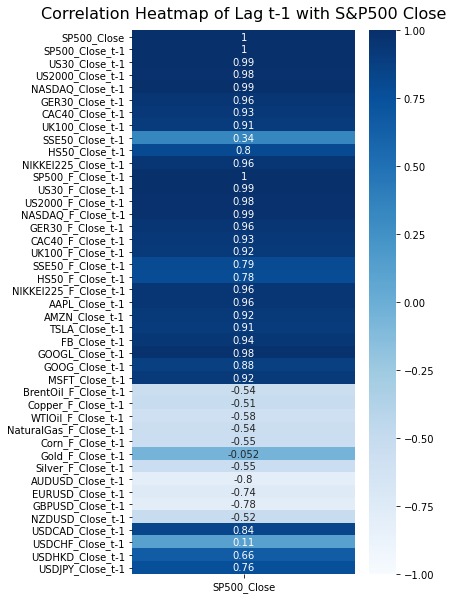

['SP500_Close_t-3', 'US30_Close_t-3', 'US2000_Close_t-3', 'NASDAQ_Close_t-3', 'GER30_Close_t-3', 'CAC40_Close_t-3', 'UK100_Close_t-3', 'SSE50_Close_t-3', 'HS50_Close_t-3', 'NIKKEI225_Close_t-3', 'SP500_F_Close_t-3', 'US30_F_Close_t-3', 'US2000_F_Close_t-3', 'NASDAQ_F_Close_t-3', 'GER30_F_Close_t-3', 'CAC40_F_Close_t-3', 'UK100_F_Close_t-3', 'SSE50_F_Close_t-3', 'HS50_F_Close_t-3', 'NIKKEI225_F_Close_t-3', 'AAPL_Close_t-3', 'AMZN_Close_t-3', 'TSLA_Close_t-3', 'FB_Close_t-3', 'GOOGL_Close_t-3', 'GOOG_Close_t-3', 'MSFT_Close_t-3', 'BrentOil_F_Close_t-3', 'Copper_F_Close_t-3', 'WTIOil_F_Close_t-3', 'NaturalGas_F_Close_t-3', 'Corn_F_Close_t-3', 'Gold_F_Close_t-3', 'Silver_F_Close_t-3', 'AUDUSD_Close_t-3', 'EURUSD_Close_t-3', 'GBPUSD_Close_t-3', 'NZDUSD_Close_t-3', 'USDCAD_Close_t-3', 'USDCHF_Close_t-3', 'USDHKD_Close_t-3', 'USDJPY_Close_t-3']


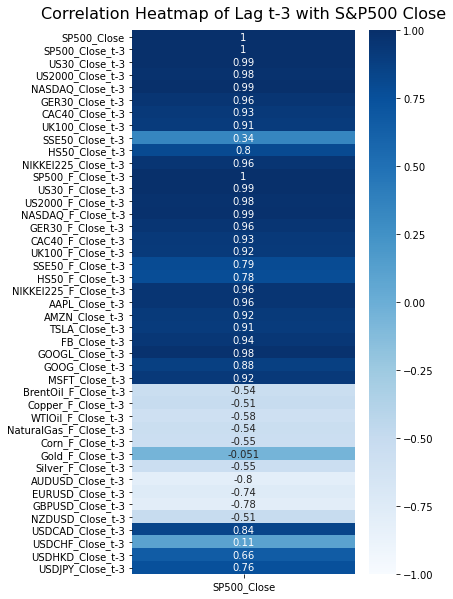

['SP500_Close_t-5', 'US30_Close_t-5', 'US2000_Close_t-5', 'NASDAQ_Close_t-5', 'GER30_Close_t-5', 'CAC40_Close_t-5', 'UK100_Close_t-5', 'SSE50_Close_t-5', 'HS50_Close_t-5', 'NIKKEI225_Close_t-5', 'SP500_F_Close_t-5', 'US30_F_Close_t-5', 'US2000_F_Close_t-5', 'NASDAQ_F_Close_t-5', 'GER30_F_Close_t-5', 'CAC40_F_Close_t-5', 'UK100_F_Close_t-5', 'SSE50_F_Close_t-5', 'HS50_F_Close_t-5', 'NIKKEI225_F_Close_t-5', 'AAPL_Close_t-5', 'AMZN_Close_t-5', 'TSLA_Close_t-5', 'FB_Close_t-5', 'GOOGL_Close_t-5', 'GOOG_Close_t-5', 'MSFT_Close_t-5', 'BrentOil_F_Close_t-5', 'Copper_F_Close_t-5', 'WTIOil_F_Close_t-5', 'NaturalGas_F_Close_t-5', 'Corn_F_Close_t-5', 'Gold_F_Close_t-5', 'Silver_F_Close_t-5', 'AUDUSD_Close_t-5', 'EURUSD_Close_t-5', 'GBPUSD_Close_t-5', 'NZDUSD_Close_t-5', 'USDCAD_Close_t-5', 'USDCHF_Close_t-5', 'USDHKD_Close_t-5', 'USDJPY_Close_t-5']


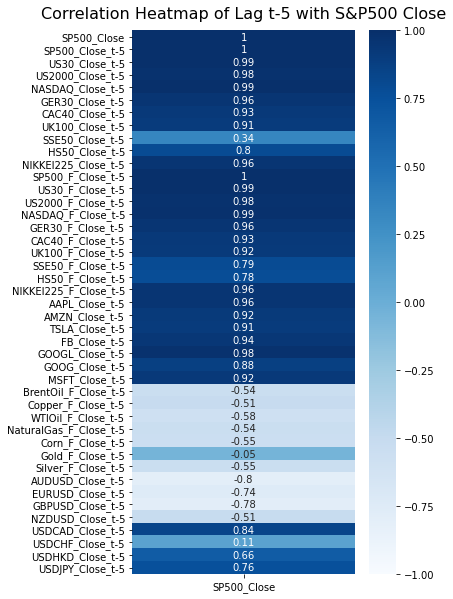

[]


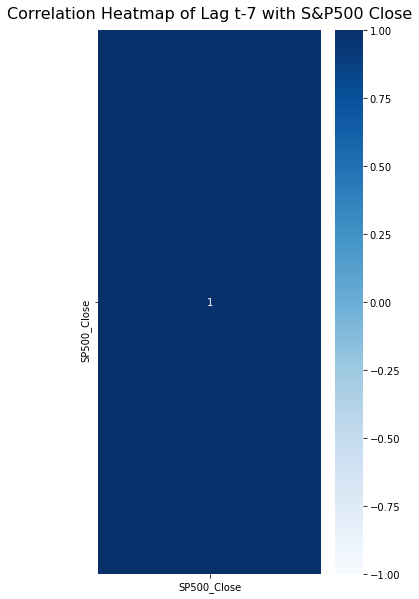

[]


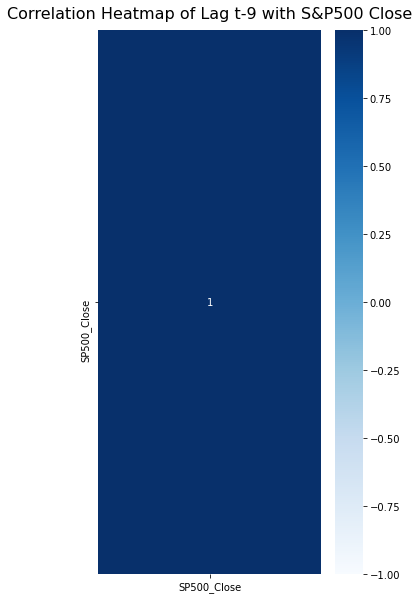

In [132]:

cols = []
for t in range(1,6):
    lag = []
    for column in df_lag.columns.tolist():
        if column[-3:] == "t-" + str(t):
            lag.append(column)
    print(lag)
    df_lag_t = df_lag[["SP500_Close"] + lag]
#     display(df_lag_t[["SP500_Close", "SP500_Close_t-1"]])
#     break
    df_close_corr = df_lag_t.corr()
#     cols.append(df_close_corr.iloc[0])
# print(cols)

    df_use = pd.DataFrame(df_close_corr.iloc[0]).transpose()
    df_use.columns = ["SP500_Close"] + lag
    df_use = df_use.transpose()

    plt.figure(figsize=(5, 10))
    heatmap = sns.heatmap(df_use, vmin=-1, vmax=1, annot=True, cmap='Blues')
    heatmap.set_title(f'Correlation Heatmap of Lag t-{t} with S&P500 Close', fontdict={'fontsize':16}, pad=12)
    plt.show()


,SP500_Close (t-1),SP500_Close (t-2),SP500_Close (t-3),SP500_Close (t-4),SP500_Close (t-5)
SP500_Close,0.981639,0.972814,0.966375,0.961351,0.957257
US30_Close,0.965357,0.959936,0.955429,0.951544,0.948097
US2000_Close,0.895473,0.892125,0.889220,0.886691,0.884233
NASDAQ_Close,0.961401,0.956685,0.952752,0.949484,0.946396
GER30_Close,0.833619,0.831225,0.829048,0.827084,0.825281
CAC40_Close,0.756960,0.754840,0.752995,0.751439,0.750029
UK100_Close,0.764963,0.763196,0.761566,0.760136,0.758978
SSE50_Close,0.200820,0.199530,0.198325,0.197311,0.196355
HS50_Close,0.567752,0.566616,0.565541,0.564626,0.563867
NIKKEI225_Close,0.761940,0.759541,0.757373,0.755315,0.753301


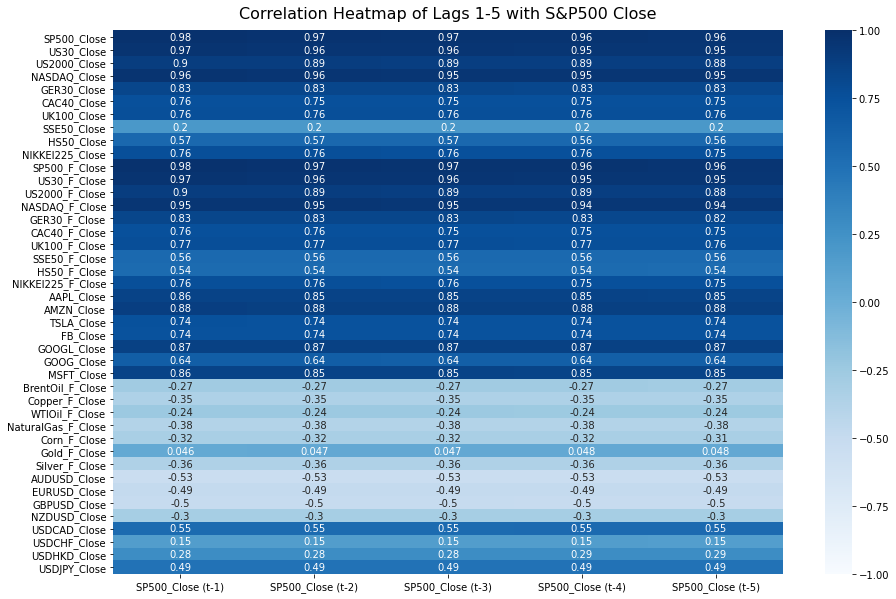

In [164]:
cols = []
df_tot = pd.DataFrame()

for t in range(1,6):
    lag = []
    for column in df_lag.columns.tolist():
        if column[-3:] == "t-" + str(t):
            lag.append(column)
    df_lag_t = df_lag[["SP500_Close"] + lag]
    df_close_corr = df_lag_t.corr(method='kendall') # spearman, pearson

    df_use = pd.DataFrame(df_close_corr.iloc[0]).transpose()
    df_use.columns = ["SP500_Close"] + lag
    df_use = df_use[lag]
    df_use = df_use.transpose()

    df_tot[f"t-" + str(t)] = df_use.reset_index(drop=True)['SP500_Close']
    
new_lag = []
for t in range(len(lag)):
    new_lag.append(lag[t][:-4])

df_tot.index = new_lag
df_tot.columns = ["SP500_Close (t-1)", "SP500_Close (t-2)", "SP500_Close (t-3)", "SP500_Close (t-4)", "SP500_Close (t-5)"]
display(df_tot)

plt.figure(figsize=(15, 10))
heatmap = sns.heatmap(df_tot, vmin=-1, vmax=1, annot=True, cmap='Blues')
heatmap.set_title(f'Correlation Heatmap of Lags 1-5 with S&P500 Close', fontdict={'fontsize':16}, pad=12)
plt.show()